In [1]:
import numpy as np

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

ООП реализация Decision tree

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch
    
        
class Leaf_clsf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        

    def predict(self):
        '''Небольшие изменения метода, используются методы библиотеки numpy.'''
        # получение классов и количество их вхождений
        classes, counts = np.unique(self.labels, return_counts=True)
        
        # получение индекса максимального значения из counts
        idx = np.argmax(counts)
        return classes[idx]
    

class Leaf_regr:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
        
    def predict(self):
        return self.targets.mean()

Добавлен критерий останова - максимальное количество листьев

In [3]:
class Base_Tree:
    
    def __init__(self, min_samples_leaf, max_depth, max_leafs, leaf_class):
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_leafs = max_leafs
        self.tree = None
        self.Leaf = leaf_class

    def _gain(self, left_labels, right_labels, root):

        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root - p * self._criterion(left_labels) - (1 - p) * self._criterion(right_labels)

    def _split(self, data, labels, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def _find_best_split(self, data, labels):

        root = self._criterion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропуск разбиений, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                current_gain = self._gain(true_labels, false_labels, root)
                #  порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index

    def _build_tree(self, data, labels):

        gain, t, index = self._find_best_split(data, labels)

        # возвращает лист, если: 
        # нет прироста информативности 
        # или по достижению максимальной глубины
        # или если кончились листья
        if gain == 0 or self.max_depth == 0 or self.max_leafs == 0:
            return self.Leaf(data, labels)

        # убывание значения максимальной глубины для каждого следующего уровня
        if self.max_depth is not None:
            self.max_depth -= 1
            
        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

        # перед построением новых веток отнимаем лист от максимального количества
        # таким образом построение новых веток будет осуществляться с учетом оставшегося количества листьев
        # при каждом разбиении минимальное количество листьев (при текущей схеме дерева) увеличивается на 1, 
        # т.к. текущий узел стал нодой, а не листом 
        if self.max_leafs is not None:
            self.max_leafs -= 1
        
        true_branch = self._build_tree(true_data, true_labels)

        false_branch = self._build_tree(false_data, false_labels)

        return Node(index, t, true_branch, false_branch)

    def _classify_object(self, obj, node):
        
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
        
    def fit(self, data, labels):
        
        # перед первым построением отнимаем лист от максимального количества
        # т.к. при вызове метода build_tree появится как минимум один лист
        if self.max_leafs is not None:
            self.max_leafs -= 1
        self.tree = self._build_tree(data, labels)
        return self
        
    def predict(self, data):
        
        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [4]:
class Classification_Tree(Base_Tree):
    
    def __init__(self, min_samples_leaf=5, max_depth=None, max_leafs=None, leaf_class=Leaf_clsf):
        super().__init__(min_samples_leaf=min_samples_leaf, 
                         max_depth=max_depth, 
                         max_leafs=max_leafs, 
                         leaf_class=Leaf_clsf)
        
    def _criterion(self, labels):
        '''В качестве критерия - энтропия Шэннона'''
        # получение количества вхождений для каждого класса
        _, counts = np.unique(labels, return_counts=True)
        
        # вероятность каждого из классов
        p = counts/np.sum(counts)
        
        # расчет энтропии
        enthropy = - np.sum(p * np.log2(p))

        return enthropy

In [5]:
class Regression_Tree(Base_Tree):
    
    def __init__(self, min_samples_leaf=5, max_depth=None, max_leafs=None, leaf_class=Leaf_regr):
        super().__init__(min_samples_leaf=min_samples_leaf, 
                         max_depth=max_depth, 
                         max_leafs=max_leafs, 
                         leaf_class=Leaf_regr)
        
    def _criterion(self, targets):
        return np.mean((targets - np.mean(targets))**2)

Реализация случайного леса как класс. Внутри метода fit реализована проверка out-of-bag. После обучения леса, можно получить среднее значение accuracy по всем деревьям в лесу. 

In [6]:
class Classification_Forest:
    
    def __init__(self, n_trees=10, max_depth=None, max_leafs=None, oob_score=False):
        self.forest = [Classification_Tree(max_depth=max_depth, max_leafs=max_leafs) for _ in range(n_trees)]
        self.oob_score = oob_score
        if oob_score:
            self.oob_score_ = None
        
    def fit(self, data, labels):
        n_samples = labels.shape[0]

        oob_predicts = []
        for tree in self.forest:
            # бутстрап
            train_idx = np.random.randint(0, n_samples, size=n_samples)
            
            # обучение дерева
            tree.fit(data[train_idx], labels[train_idx])
            
            # out-of-bag
            if self.oob_score:
                # различие между индексами всей выборки и попавших в бутстрап
                test_idx = np.setdiff1d(np.array(range(labels.shape[0])), train_idx)
                # подсчет accuracy 
                acc = np.mean(np.array(tree.predict(data[test_idx]) == labels[test_idx]))
                oob_predicts.append(acc)
                
        # подсчет среднего значения
        if self.oob_score:
            self.oob_score_ = np.mean(oob_predicts)
            
        return self
            
    def predict(self, data):
        return self.__tree_vote(data)
            
    def __tree_vote(self, data):
        
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
            
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))
            
        return voted_predictions

In [7]:
from sklearn.datasets import make_classification, make_regression
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score


X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_classes=2, n_redundant=0, random_state=123)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
%%time
forest_1 = Classification_Forest(oob_score=True, n_trees=1)
forest_1.fit(X_train, y_train)

print(f'Out-of-Bag score: {forest_1.oob_score_}')

Out-of-Bag score: 0.8518518518518519
CPU times: user 24.8 ms, sys: 4.5 ms, total: 29.3 ms
Wall time: 27.3 ms


In [10]:
%%time
forest_3 = Classification_Forest(oob_score=True, n_trees=3)
forest_3.fit(X_train, y_train)

print(f'Out-of-Bag score: {forest_3.oob_score_}')

Out-of-Bag score: 0.9002849002849004
CPU times: user 66.4 ms, sys: 2.81 ms, total: 69.2 ms
Wall time: 67.1 ms


In [11]:
%%time
forest_10 = Classification_Forest(oob_score=True, n_trees=10)
forest_10.fit(X_train, y_train)

print(f'Out-of-Bag score: {forest_10.oob_score_}')

Out-of-Bag score: 0.8234574732835602
CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 210 ms


In [12]:
%%time
forest_50 = Classification_Forest(oob_score=True, n_trees=50)
forest_50.fit(X_train, y_train)

print(f'Out-of-Bag score: {forest_50.oob_score_}')

Out-of-Bag score: 0.8499767079053434
CPU times: user 953 ms, sys: 4 ms, total: 957 ms
Wall time: 955 ms


In [14]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, train_labels, test_data, test_labels, model):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = y_train, cmap = colors)
    plt.title(f'Train accuracy={accuracy_score(train_labels, model.predict(train_data)):.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={accuracy_score(test_labels, model.predict(test_data)):.2f}')

Одно дерево

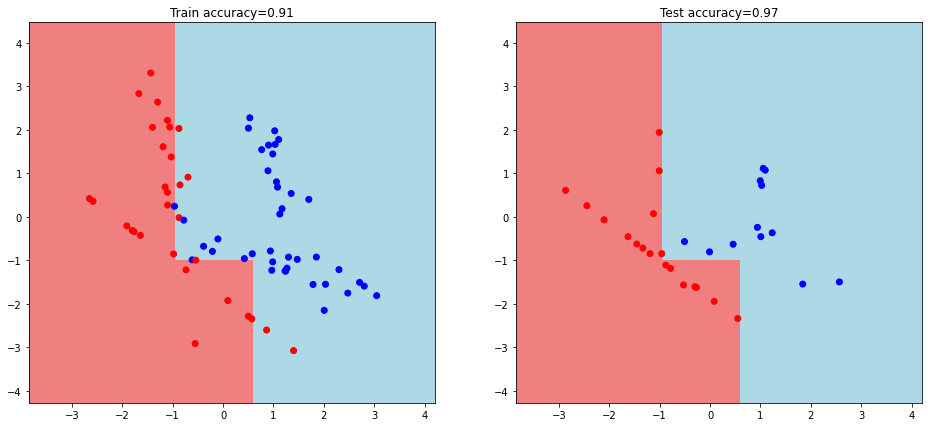

In [15]:
visualize(X_train, y_train, X_test, y_test, forest_1)

Три дерева

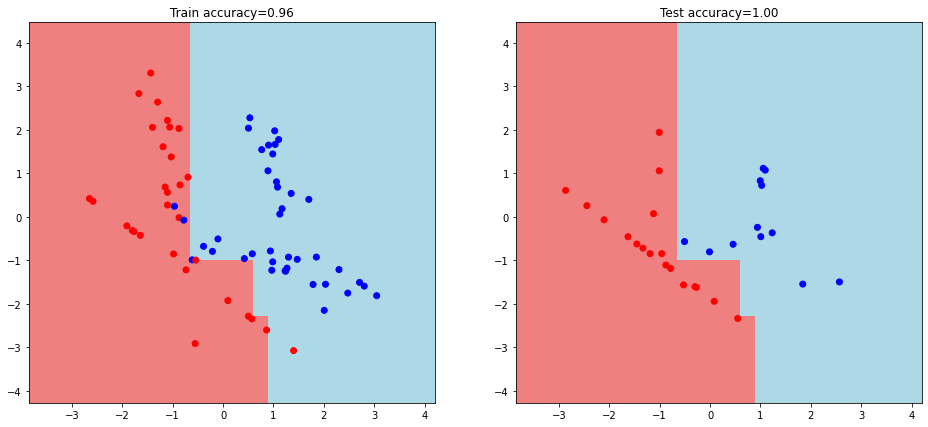

In [16]:
visualize(X_train, y_train, X_test, y_test, forest_3)

Десять деревьев

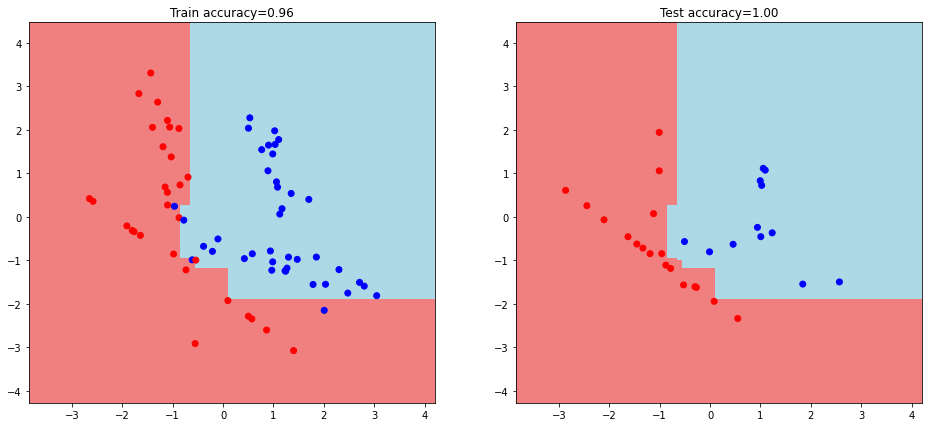

In [17]:
visualize(X_train, y_train, X_test, y_test, forest_10)

Пятьдесят деревьев

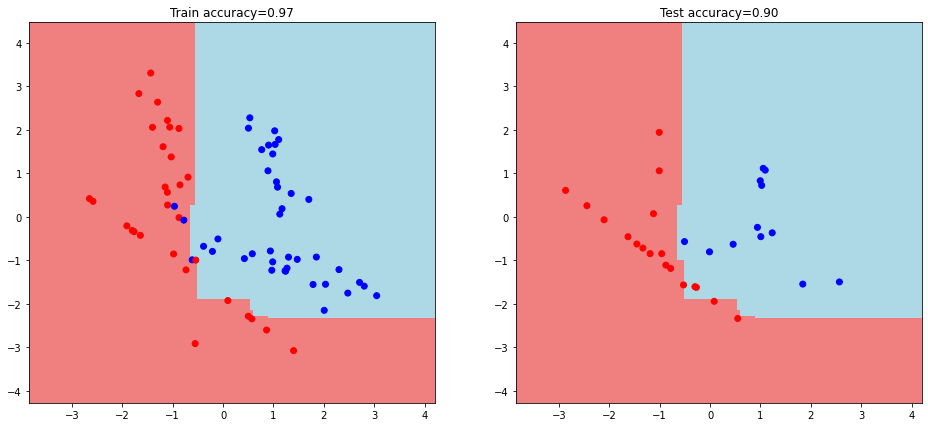

In [18]:
visualize(X_train, y_train, X_test, y_test, forest_50)

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

С увеличением количества деревьев возрастает сложность разделяющей гиперплоскости. Это связано с тем, что при обучении увеличивается вариативность - увеличивается количество случайных сочетаний в обучающих данных (больше бутстрап выборок). 

На таком малом наборе данных трудно сделать выводы, относительно склонности модели к недообучению или переобучению, в зависимости от количества деревьев в ней. У случайного леса более высокая устойчивость к переобучению, в отличии от одиночного дерева решений, т.к. каждое из деревьев обучается не на всей обучающей выборке, а только на части данных (бутстрап выборке). А затем предсказание модели усредняется по всем деревьям. Но при значительном увеличении количества деревьев модель неминуемо переобучится, по причине того, что все бутстрап выборки будут сгенерированы из ограниченного набора данных - обучающей выборки.

### 3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Реализовано выше, внутри метода fit, в классе Classification_Forest.

### 4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

$$ entropy = -\sum_{i = 1}^{n} p_i \log_2{p_i} $$

Реализовано выше, внутри класса Classification_Tree. 

В виде отдельной функции:

In [19]:
def entropy(labels):
    # получение количества вхождений для каждого класса
    _, counts = np.unique(labels, return_counts=True)
    
    # вероятности для каждого из классов
    p = counts/np.sum(counts)
    
    # расчет энтропии
    entropy = -np.sum(p * np.log2(p))
    
    return entropy

Проверка

In [20]:
a = np.random.randint(0, 2, size=10)
b = np.zeros(shape=10)

entropy(a), entropy(b)

(0.9709505944546686, -0.0)